In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical

Using TensorFlow backend.
/home/ggj/anaconda3/envs/pytorch-cuda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ggj/anaconda3/envs/pytorch-cuda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ggj/anaconda3/envs/pytorch-cuda2/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gg

In [2]:
batch_size = 100
original_dim = 784
latent_dim = 2 # 隐变量取2维只是为了方便后面画图
intermediate_dim = 256
epochs = 100
num_classes = 10

In [3]:
# 加载MNIST数据集
(x_train, y_train_), (x_test, y_test_) = mnist.load_data(path="/home/ggj/jiaqiLi/mount-1/ggj/.keras/datasets/mnist.npz")
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
y_train = to_categorical(y_train_, num_classes)
y_test = to_categorical(y_test_, num_classes)

In [4]:
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)

# 算p(Z|X)的均值和方差
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

y = Input(shape=(num_classes,)) # 输入类别
yh = Dense(latent_dim)(y) # 这里就是直接构建每个类别的均值

# 重参数技巧
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=K.shape(z_mean))
    return z_mean + K.exp(z_log_var / 2) * epsilon

# 重参数层，相当于给输入加入噪声
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# 解码层，也就是生成器部分
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# 建立模型
vae = Model([x, y], [x_decoded_mean, yh])

In [5]:
# xent_loss是重构loss，kl_loss是KL loss
xent_loss = K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=-1)

# 只需要修改K.square(z_mean)为K.square(z_mean - yh)，也就是让隐变量向类内均值看齐
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean - yh) - K.exp(z_log_var), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
# add_loss是新增的方法，用于更灵活地添加各种loss
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()

vae.fit([x_train, y_train], 
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=([x_test, y_test], None))

/home/ggj/anaconda3/envs/pytorch-cuda2/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_6 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_6.
  'be expecting any data to be passed to {0}.'.format(name))
/home/ggj/anaconda3/envs/pytorch-cuda2/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output dense_4 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to dense_4.
  'be expecting any data to be passed to {0}.'.format(name))


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
____________________________________________________________________________________________

60000/60000 [==============================] - 4s 65us/step - loss: 147.7196 - val_loss: 150.1516
Epoch 52/100
60000/60000 [==============================] - 4s 66us/step - loss: 147.6469 - val_loss: 150.1815
Epoch 53/100
60000/60000 [==============================] - 4s 67us/step - loss: 147.5722 - val_loss: 149.8681
Epoch 54/100
60000/60000 [==============================] - 4s 68us/step - loss: 147.4914 - val_loss: 149.6905
Epoch 55/100
60000/60000 [==============================] - 4s 66us/step - loss: 147.4027 - val_loss: 150.2290
Epoch 56/100
60000/60000 [==============================] - 4s 65us/step - loss: 147.3333 - val_loss: 149.6978
Epoch 57/100
60000/60000 [==============================] - 4s 67us/step - loss: 147.2690 - val_loss: 149.7293
Epoch 58/100
60000/60000 [==============================] - 4s 64us/step - loss: 147.1952 - val_loss: 149.7486
Epoch 59/100
60000/60000 [==============================] - 4s 65us/step - loss: 147.1253 - val_loss: 149.7493
Epoch 60/100
6

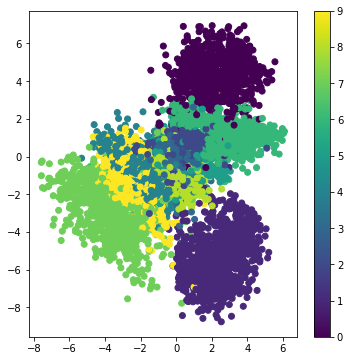

In [8]:
# 构建encoder，然后观察各个数字在隐空间的分布
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test_)
plt.colorbar()
plt.show()

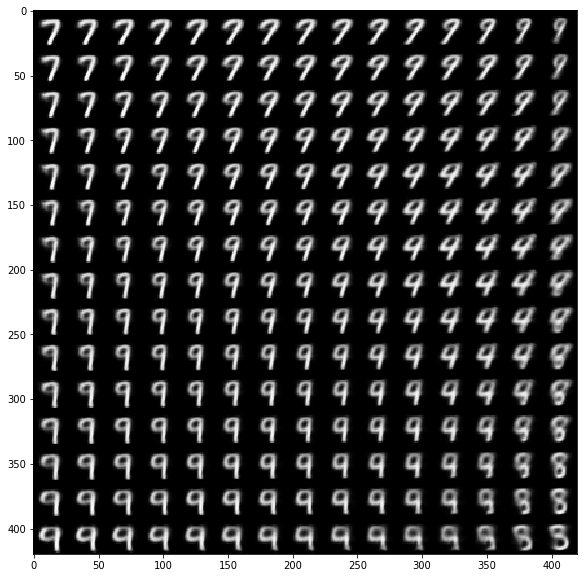

In [9]:
# 构建生成器
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# 输出每个类的均值向量
mu = Model(y, yh)
mu = mu.predict(np.eye(num_classes))

# 观察能否通过控制隐变量的均值来输出特定类别的数字
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

output_digit = 9 # 指定输出数字

# 用正态分布的分位数来构建隐变量对
grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) + mu[output_digit][1]
grid_y = norm.ppf(np.linspace(0.05, 0.95, n)) + mu[output_digit][0]

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()